# **Dataset description**

textID (text – object type) – unique tweet ID;

text (text – object type) – text of message;

selected_text (text – object type) – message text selected to determine sentiment;

sentiment (text – object type) – sentiment of the tweet (neutral, positive or negative);

Time of Tweet (text – object type) – tweet creation period (morning, noon, night);

Age of User (text – object type) – age of user (0-20, 21-30, 31-45, 46-60, 60-70, 70-100);

Country (text – object type) – country of the user who wrote the tweet (195 countries);

Population -2020 (integer - int) –  population of country in 2020;

Land Area (Km²) (float) – area of country (кm²);

Density (P/Km²) (integer – int) – country population density.


In [ ]:
# Import required libraries
import os
import re
import time
import warnings
import nltk
import numpy as np
import pandas as pd  # import Pandas for processing and data analysis
import matplotlib.pyplot as plt

# from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, \
    precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
from string import punctuation  # for solving punctuation problems
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download("stopwords")  # delete stop-words
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
!pip install contractions
import contractions

In [ ]:
# Loading a dataset
# Reading data from a CSV file using the read_csv function and writing it to the df variable
df = pd.read_csv('train.csv', delimiter=',', encoding='ISO-8859-1')
# Change the encoding to utf-8
df = df.applymap(lambda x: str(x).encode("utf-8", errors='surrogatepass').decode("ISO-8859-1", errors='surrogatepass'))

In [ ]:
pd.options.display.max_columns = None  # Get rid of the limit on displaying columns
df = df.reset_index(drop=True)
print(df.head())  # Let's look at the first 5 lines of the dataframe

       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet Age of User  \
0  I`d have responded, if I were going   neutral       morning        0-20   
1                             Sooo SAD  negative          noon       21-30   
2                          bullying me  negative         night       31-45   
3                       leave me alone  negative       morning       46-60   
4                        Sons of ****,  negative          noon       60-70   

       Country Population -2020 Land Area (Km²) Density (P/Km²)  
0  Afghanistan         38928346        652860.0         

In [ ]:
print(df.describe(include="all")) # Let's see the description of dataset

            textID                                               text  \
count        27481                                              27481   
unique       27481                                              27481   
top     6f7127d9d7     All this flirting going on - The ATG smiles...   
freq             1                                                  1   

       selected_text sentiment Time of Tweet Age of User      Country  \
count          27481     27481         27481       27481        27481   
unique         22431         3             3           6          195   
top             good   neutral       morning        0-20  Afghanistan   
freq             199     11118          9161        4581          149   

       Population -2020 Land Area (Km²) Density (P/Km²)  
count             27481           27481           27481  
unique              195             193             136  
top            38928346           700.0              25  
freq                149             

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   textID            27481 non-null  object
 1   text              27481 non-null  object
 2   selected_text     27481 non-null  object
 3   sentiment         27481 non-null  object
 4   Time of Tweet     27481 non-null  object
 5   Age of User       27481 non-null  object
 6   Country           27481 non-null  object
 7   Population -2020  27481 non-null  object
 8   Land Area (Km²)   27481 non-null  object
 9   Density (P/Km²)   27481 non-null  object
dtypes: object(10)
memory usage: 2.1+ MB
None


# Preliminary analysis

In [ ]:
# Preliminary analysis
print(df.nunique())  # Number of unique values in columns

textID              27481
text                27481
selected_text       22431
sentiment               3
Time of Tweet           3
Age of User             6
Country               195
Population -2020      195
Land Area (Km²)       193
Density (P/Km²)       136
dtype: int64


In [ ]:
print(df.isna().sum())  # Number of zero values

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64


For a detailed analysis, let’s look at the distribution of tweets by time, sentiment, and the maximum line length in “selected_text”, i.e. length before processing, and also check for duplicates using the code:

In [ ]:
print(df['Time of Tweet'].value_counts())  # Let's look at the distribution of tweets over time

Time of Tweet
morning    9161
noon       9160
night      9160
Name: count, dtype: int64


Распределение одинаково

In [ ]:
# Let's look at the maximum line length in the selected_text column
print(int(df['selected_text'].str.encode(encoding='UTF-8').str.len().max()))
print(int(df['selected_text'].str.encode(encoding='UTF-8').str.len().min()))

302
1


In [ ]:
print(df.duplicated().sum())  # Printing duplicates if available


0


No duplicates found

In [ ]:
print(df['sentiment'].value_counts())  # Let's look at the distribution of tweets by mood

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64


The distribution of tweets by time of day is the same, there are no duplicates, the maximum length of a tweet before processing in “selected_text” is 302 characters.

For clarity, the distribution of reviews by sentiment will be plotted in a pie chart.

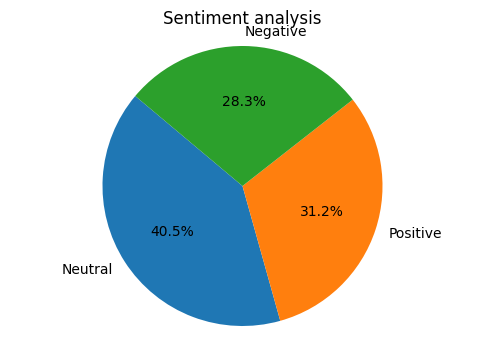

In [ ]:
# Let's visualize the distribution of sentiment (test for normality) using a pie chart.
plt.figure(figsize=(6, 4))
plt.pie(df['sentiment'].value_counts(), labels=['Neutral', 'Positive', 'Negative'], autopct='%1.1f%%',
        radius=1, startangle=140)
plt.title('Sentiment analysis')  # Chart title
plt.axis('equal')  # Equal ensures that the circle is drawn as a circle.
plt.show()  # Show Pie Chart

The chart shows that the data is slightly unbalanced. Since the imbalance is small, we will not balance the Dataset.

Let's look at the number of tweets by country

In [ ]:
countries = df['Country'].value_counts(ascending=False).head(7)  # Let's look at the top 7 countries with the most tweets
print(countries)
countries_min = df['Country'].value_counts(ascending=False).tail(7)  # Let's look at the 7 countries with the fewest tweets
print(countries_min)

Country
Afghanistan            149
Albania                149
Algeria                149
Andorra                149
Angola                 149
Antigua and Barbuda    149
Argentina              149
Name: count, dtype: int64
Country
Uzbekistan    127
Vanuatu       127
Venezuela     127
Vietnam       127
Yemen         127
Zambia        127
Zimbabwe      127
Name: count, dtype: int64


The number of tweets in 195 countries varies from 149 to 127.

In [ ]:
country_of_tweets = df.groupby('Country')['sentiment'].value_counts(ascending=True)
ct = country_of_tweets.groupby(['Country', 'sentiment']).sum().unstack()
print(ct)

sentiment    negative  neutral  positive
Country                                 
Afghanistan        40       66        43
Albania            47       59        43
Algeria            51       55        43
Andorra            47       54        48
Angola             48       54        47
...               ...      ...       ...
Venezuela          19       56        52
Vietnam            29       56        42
Yemen              42       49        36
Zambia             32       44        51
Zimbabwe           37       45        45

[195 rows x 3 columns]


Age of User
0-20      4581
21-30     4580
31-45     4580
46-60     4580
60-70     4580
70-100    4580
Name: count, dtype: int64


<Axes: xlabel='Age of User'>

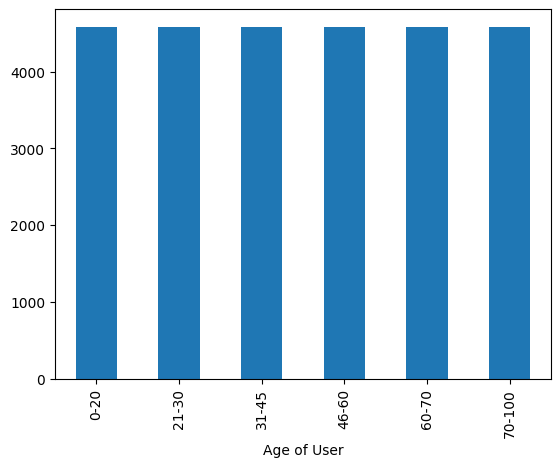

In [ ]:
age = df['Age of User'].value_counts(ascending=False)  # Let's look at the number of tweets by age
print(age)
age.plot.bar()

The total number of tweets is the same.

In [ ]:
# Let's look at the number of tweets of different tones by age
age_of_tweets = df.groupby('Age of User')['sentiment'].value_counts(ascending=True)
at = age_of_tweets.groupby(['Age of User', 'sentiment']).sum().unstack()
print(at)

sentiment    negative  neutral  positive
Age of User                             
0-20             1290     1898      1393
21-30            1336     1830      1414
31-45            1315     1814      1451
46-60            1271     1865      1444
60-70            1266     1845      1469
70-100           1303     1866      1411


The quantity is approximately the same.

# Preprocessing

Let's remove one empty line in the columns with text, as well as columns that do not contain information that affects the analysis. The most important thing for sentiment analysis is the selected text in the “selected_text” column, so the “text” column can also be removed.

In [ ]:
df = df.dropna()  # Remove the empty line

In [ ]:
df.drop(['textID', 'Country',  'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)', 'Age of User', 'Time of Tweet',
         'text'], axis='columns', inplace=True)
print(df.info())
print(df.describe()) # print a summary of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   selected_text  27481 non-null  object
 1   sentiment      27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB
None
       selected_text sentiment
count          27481     27481
unique         22431         3
top             good   neutral
freq             199     11118


We will process and clean the text so that it can be used in machine learning algorithms. To do this, we will create a column “clean_text” based on “selected_text” and clear the text in this column from non-alphabetic characters, numbers, URLs, stop words, convert words to lower case, divide the text into tokens, carry out stemming - bringing words to the basic lemma. Then we will delete messages consisting of 0 and 1 characters, since semantically important words in English consist of at least 2 letters (pronouns are included in the list of stop words and will be sorted earlier).

In [ ]:
# Create a column for cleared text
df['clean_text'] = df['selected_text']

In [ ]:
def clean_text(text):
    # Let's start cleaning the text
    text = re.sub(r"\'", " ", text)  # match the quotes and replace
    text = re.sub('https?://\S+|www\.\S+|@\w+', ' ', text)
    text = re.sub('\xa0', ' ', text)  # match non-breaking space and replace
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\s+', ' ', text)  # match one or more spaces and replace
    text = text.strip(' ')
    return text


df['clean_text'] = df['clean_text'].apply(lambda x: clean_text(x))  # Let's use the function to clear text

In [ ]:
def expand_contractions(text):
    # remove abbreviations, for example correct'don't' to 'do not'
    text = contractions.fix(text)
    return text


df['clean_text'] = df['clean_text'].apply(lambda x: expand_contractions(x))

In [ ]:
df['clean_text'] = df['clean_text'].str.lower() # Convert letters to lowercase
print(df.head())

                         selected_text sentiment  \
0  I`d have responded, if I were going   neutral   
1                             Sooo SAD  negative   
2                          bullying me  negative   
3                       leave me alone  negative   
4                        Sons of ****,  negative   

                            clean_text  
0  i`d have responded, if i were going  
1                             sooo sad  
2                          bullying me  
3                       leave me alone  
4                        sons of ****,  


In [ ]:
def remove_numbers(text):  # takes a string and returns pure text
        output = ''.join(c for c in text if not c.isdigit())  # Used regular expression to remove numbers
        return output


df['clean_text'] = df['clean_text'].apply(lambda x: remove_numbers(x))

In [ ]:
def remove_punctuation(text):
    # remove all punctuation
    return ''.join(c for c in text if c not in punctuation)


df['clean_text'] = df['clean_text'].apply(lambda x: remove_punctuation(x))

In [ ]:
def remove_non_alphabetical_character(text):
    text = re.sub("[^a-z]+", " ", text)  # remove non-alphabetic characters
    text = re.sub("\s+", " ", text)  # remove spaces left after the last operation
    return text


df['clean_text'] = df['clean_text'].apply(lambda x: remove_non_alphabetical_character(x))

In [ ]:
def remove_single_letter(text):
    text = re.sub(r"\b\w{1}\b", "", text)  # remove single alphabetic characters
    text = re.sub("\s+", " ", text)  # remove spaces left after the last operation
    text = text.strip(" ")
    return text


df['clean_text'] = df['clean_text'].apply(lambda x: remove_single_letter(x))
print(df.head())

                         selected_text sentiment  \
0  I`d have responded, if I were going   neutral   
1                             Sooo SAD  negative   
2                          bullying me  negative   
3                       leave me alone  negative   
4                        Sons of ****,  negative   

                        clean_text  
0  id have responded if were going  
1                         sooo sad  
2                      bullying me  
3                   leave me alone  
4                          sons of  


In [ ]:
stop_words = stopwords.words('english')  # Remove stop words
print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [ ]:
# Let's add some stop-words just in case.
more_stopwords = ['im', 'id', "youre", "youve", "youll", "youd", 'shell', "shes", 'theyre', 'whichll', 'wholl',
                  "thatll", 'dont', 'cant', 'didnt', "shouldve", 'arent', 'couldnt', 'doesnt', 'hadnt', "hasnt",
                  'havent',  "isnt", "mightnt", "mustnt", "neednt", "shant", "shouldnt", "wasnt", "werent", "wont",
                  "wouldnt", "kã¯", "am", 'youon', "would", "shall", "ve", "ive", "weve", "anyth", "anythi", "sooo",
                  "soo", "us", "th", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l" "p", "q", "r", "s", "m",
                  "n", "t", "u", "w", "x", "z", "ll", 're']  # Let's also remove single letters that are not needed

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
stop_words = stop_words + more_stopwords


def remove_stopwords(text):  # Function to remove stop words
    words = nltk.word_tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str, filtered))  # Return the text untokenize


df['clean_text'] = df['clean_text'].apply(lambda x: remove_stopwords(x))  # apply the function to the text column
print(df.head())

                         selected_text sentiment       clean_text
0  I`d have responded, if I were going   neutral  responded going
1                             Sooo SAD  negative              sad
2                          bullying me  negative         bullying
3                       leave me alone  negative      leave alone
4                        Sons of ****,  negative             sons


In [ ]:
stemmer = nltk.SnowballStemmer("english")


# Stemming — refers to the removal of «ing», «ly», «s» etc
# Stemming is the reduction of words to a basic form
def stem_text(text):
    words = nltk.word_tokenize(text)  # tokenize the text and then return a list of tuples (token, nltk_tag)
    stem_text = []
    for word in words:
        stem_text.append(stemmer.stem(word))
    return " ".join(stem_text)  # Returning non-tokenized text


df['clean_text'] = df['clean_text'].apply(lambda x: stem_text(x))

In [ ]:
print(df['clean_text'].head())  # look at the cleaned text

0    respond go
1           sad
2         bulli
3     leav alon
4           son
Name: clean_text, dtype: object


In [ ]:
df.drop(['selected_text'], axis='columns', inplace=True)
# Let's delete the unnecessary column, because there is a clean_text column

In [ ]:
# Let's look at frequently used words
freq = pd.Series(' '.join(df['clean_text']).split()).value_counts()[:10]
print(freq)

go       1510
good     1265
day      1225
love     1207
get      1041
happi     863
like      851
work      838
miss      801
thank     793
Name: count, dtype: int64


In [ ]:
# Let's look at rare words, they can create noise, it is better to remove them
rarely = pd.Series(' '.join(df['clean_text']).split()).value_counts()[-10:]
print(rarely)

colossus     1
malamang     1
dnw          1
holler       1
carbonara    1
pina         1
pque         1
cheescak     1
shld         1
aftrn        1
Name: count, dtype: int64


In [ ]:
# We will remove words that occur less than 6 times to reduce the number of features.
all_ = [x for y in df['clean_text'] for x in y.split(' ')]
a, b = np.unique(all_, return_counts=True)
to_remove = a[b < 6]
df['clean_text'] = [' '.join(np.array(y.split(' '))[~np.isin(y.split(' '), to_remove)])
                    for y in df['clean_text']]
rarely = pd.Series(' '.join(df['clean_text']).split()).value_counts()[-10:]
print(rarely)

outfit     6
pen        6
male       6
pot        6
darl       6
grea       6
curs       6
receiv     6
restaur    6
gold       6
Name: count, dtype: int64


In [ ]:
# Let's look at the maximum line length in the cleared text
print(int(df['clean_text'].str.encode(encoding='UTF-8').str.len().max()))
print(int(df['clean_text'].str.encode(encoding='UTF-8').str.len().min()))
# Let's delete lines in which the length is less than 2, because there cannot be words of the same letter
df = df[df['clean_text'].apply(lambda x: len(x) > 1)]
print(int(df['clean_text'].str.encode(encoding='UTF-8').str.len().min()))  # Let's check the removal of lines with 0 and 1 characters

94
0
2


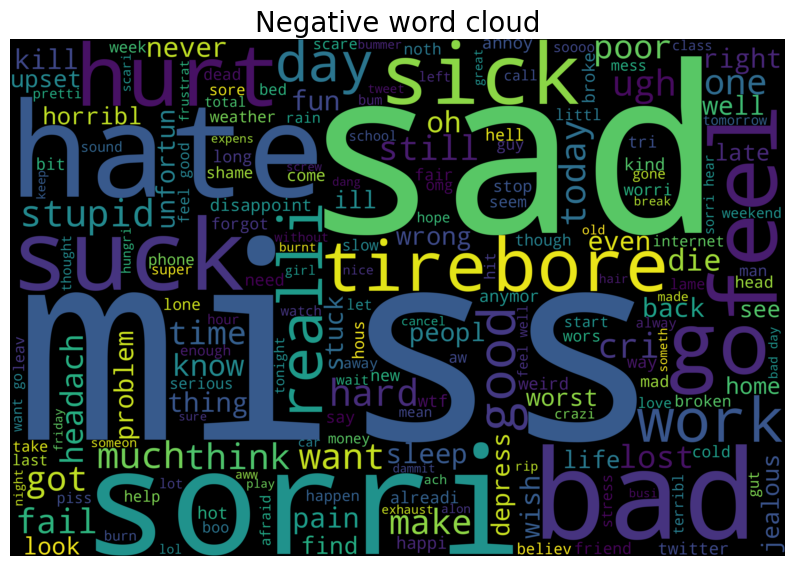

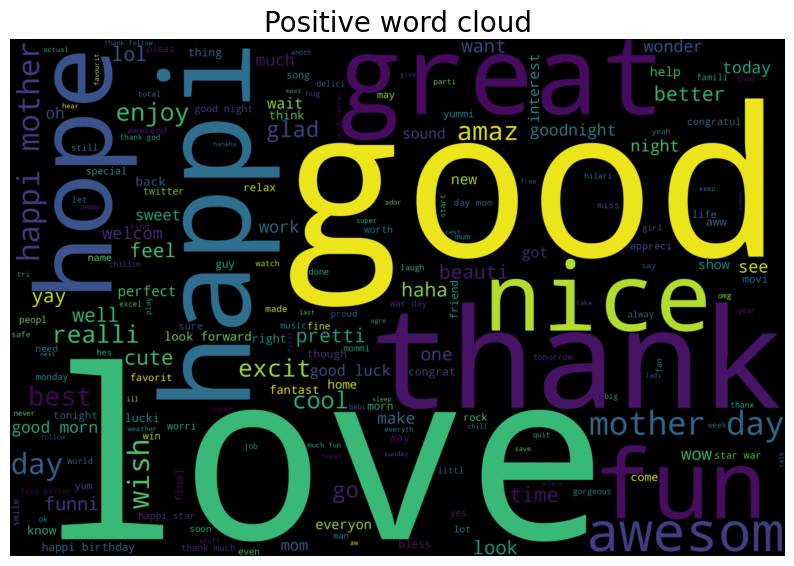

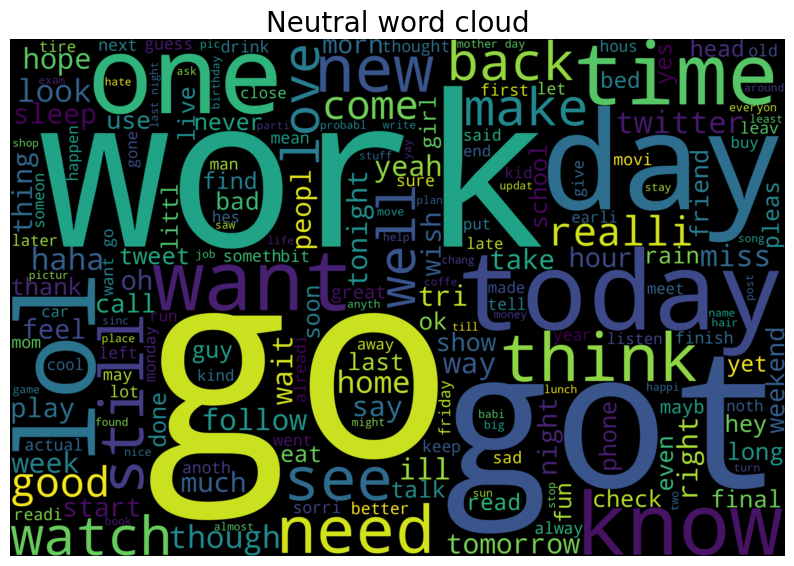

In [ ]:
# Let's look at a cloud of negative, positive and neutral words.
df_pos = df[df['sentiment'] == 'positive']
df_neg = df[df['sentiment'] == 'negative']
df_neut = df[df['sentiment'] == 'neutral']


def generate_wordcloud(data, title):  # Function for generating and displaying word clouds
    words = ' '.join(data['clean_text'])
    cleaned_word = " ".join([word for word in words.split()
                             # We exclude words from URLs, as well as words that begin with @
                             if 'http' not in word and not word.startswith('@') and word != 'RT'])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',  # word cloud background
                      width=3000,  # width
                      height=2000  # height
                      ).generate(cleaned_word)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()


# We call the function to generate a word clouds
generate_wordcloud(df_neg, 'Negative word cloud')
generate_wordcloud(df_pos, 'Positive word cloud')
generate_wordcloud(df_neut, 'Neutral word cloud')

In [ ]:
# Let's look at the cleaned text
print(df.head())
print(df.info())
print(df.describe())

  sentiment       clean_text
0   neutral       respond go
1  negative              sad
3  negative        leav alon
4  negative              son
5   neutral  plug best earth
<class 'pandas.core.frame.DataFrame'>
Index: 25940 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentiment   25940 non-null  object
 1   clean_text  25940 non-null  object
dtypes: object(2)
memory usage: 608.0+ KB
None
       sentiment clean_text
count      25940      25940
unique         3      16318
top      neutral       love
freq       10781        527


# **Overview of Ensemble Machine Learning Methods**
Having carried out a preliminary analysis and preprocessing of data, we can proceed to the consideration of ensemble models with the subsequent assumption of the most effective of them. In my opinion, the best way to describe the concept of ensemble methods is to give the following figurative example. We often discuss with family and friends, or with experts in the field, or look at reviews, reviews of the topic on social networks when making important decisions in life. Thus, taking into account the opinions of other people and experts, we make a choice in favor of a more informed decision on an important issue, since several opinions are combined when making a decision. The critical decision-making process described here illustrates how ensemble methods work by combining predictions from multiple models to create a final model with the best performance. Depending on how the models are combined, there are four different types of ensemble learning: bagging, boosting, voting, and stacking.


## Bagging
**Bagging** (short for “Bootstrap Aggregating”) consists of independently building several predictors and then averaging them to obtain a final combined forecast, thereby increasing the stability and accuracy of machine learning algorithms. This method can reduce the variance without any prediction errors. Bagging is primarily applied to Decision Trees methods, but it can also be used with any type of machine learning methods. Moreover, when solving regression problems, the average value of the output data is taken, and in classification problems, as in our case, the majority of votes is taken. Bagging can be figuratively represented as decision-making when choosing a candidate for the position of CEO by each member of the board of directors, and the decision is made on the basis of all votes. The undoubted advantage of bagging is that when constructing independent models for evaluation, parallel processing occurs, which increases the speed of work. The most popular estimator in bagging is Bagging Trees, better known as Random Forest, which randomly splits a Dataset and trains multiple decision trees on subsets of the data. The peculiarity of this model is the selection of random features. If we move the random forest into the image space, then when choosing a CEO, members of the board of directors evaluate candidates from the point of view of one randomly selected area that is most important to them, for example, the ability to speak, draw up business plans, ability to sell, ability to lead, ability to achieve results in a short time, etc.

Random forest or random decision forests for solving different problems build many decision trees during training while correcting the latter's habit of overfitting. For this reason, the efficiency of random forest is superior to that of decision trees. In addition, decision trees are so overfitted that they perform worse than a linear regression model.

## Boosting
In **boosting**, machine learning models are used one after another, and the predictions made by the first level models are used as input to the next level models. The final layer of models will use the predictions of all previous layers to make the final prediction. That is, boosting allows each subsequent model to improve the performance of the previous one by overcoming or reducing the error of the previous model. In the case of boosting, the basic learning ability increases due to sequential training on a weighted version of the data. So, figuratively speaking, boosting can be described using the following example. When recruting a new specialist, an employee of the HR department takes as a basis the assessment of the candidate by a previous specialist, for example, the head of a department, employees of related departments with whom the new employee will interact, as well as recommendations from previous places of work (if any).

Boosting is used to solve both regression and classification problems. There are different types of boosting algorithms, for example: Gradient Boosting Machine (GBM), eXtreme Gradient Boosting Machine (XGBoost), LightGBM, CatBoost. Gradient boosting (GBM) involves optimizing the loss function of a weak learner in predictions and an additive model for adding weak learners to minimize the loss function. It is a greedy algorithm that can transform the learning data set quickly. XGBoost is quite popular in solving competitive applied machine learning problems and is an improved version of gradient boosting (GBM) due to system optimization and algorithm improvements. XGBoost is an implementation of gradient boosted decision trees to make the most efficient use of available resources for model training. XGBoost is free and open source software. Applications of XGBoost include an implementation of Sparse Aware with automatic handling of missing data, a block structure for parallelizing tree construction.
Let us give several examples to compare gradient and extreme gradient boosting. In the case of gradient boosting, insufficiently suitable candidates are rejected at an early stage. For example, in a racing championship, where the main differences will be excellent driving skills and a good sports car, someone takes the lead immediately, thanks to the characteristics described above, the rest may not fit into the turn, or something in the sports car may fail, so immediately it is clear who is rejected and who is leading the race. With extreme gradient boosting, the same thing happens even faster. Having a good sports car, excellent driving skills, in addition to all of the above, high octane fuel is added, which gives the same acceleration, making the completion of the same lap many times faster. Thus, XGBoost is the best combination of performance and time.

## Voting
The name of the **voting** method speaks for itself. Voting is the simplest method of combining the votes of several models with a voting classifier. The selection of combinations of basic models is carried out by analyzing the construction of ensemble classifiers. When voting, one decision is made out of several possible ones.

There are two types of voting – soft and hard. In hard voting, each estimator makes a prediction, and the ensemble voting method's prediction is majority voting. With soft voting, the reliability of the predictions of each classifier is also taken into account, assigning a probability to each candidate, and the forecast of the ensemble soft voting method is the class with the highest overall probability. Thus, when voting, several autonomous, equally effective models are used, after which the voting classifier comes into play, which is a kind of wrapper for the models and averages the forecasts of independent evaluators.

As an example of hard voting, we give the following. Suppose a vote is taken by writing one of the given options by each voting participant on a piece of paper and putting it in the voting hat, for instance, when choosing one of three restaurants for a corporate party. In this case, the restaurant with the most employee votes is selected. For soft voting, an obvious example is elections, for example, the election of the mayor of a city, where when counting votes given to different candidates, the percentage of votes cast for each of them is also taken into account.
In our case, the choice was made in favor of soft voting, since this ensemble voting method is more accurate compared to hard voting.

## Stacking
And the last type is **stacking**. Stacking is an ensemble algorithm that best combines the predictions of several well-performing machine learning models. The stacking structure is two-tiered. The structure consists models of a Level 0 (base-level) and model of a Level 1 (meta-level). Base-level models are trained using a training dataset and then make a prediction. The metamodel is then trained using the metadata to identify the base-level models output as a class label, so the meta-level model learns how to best combine the base models' predictions. Typically, for stacking, various models are used as base models, and logistic regression is used as a meta-model in the classification task.

Thus, stacking combines different underlying algorithms into one, as opposed to bagging, which combines identical models. Stacking occurs with the help of a trained metamodel, which leads to a reduction in systematic errors of the base models. The final classifier (Stacking Classifier) is trained using cross-validation, with a default of 5 folds, which makes it more time-consuming compared to previous ensembles.
As an example, we can take the Agile approach when creating an application, where several different groups work in a team, the result of their activities is a finished product, which consists of the activities of the following conditional groups in our specific example: product owner, coordinator, full-stack developer.

# Train-test split

In [ ]:
x = df['clean_text']
y = df['sentiment']  # tweet sentiment assessment
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2, train_size=0.8)
le = LabelEncoder()  # To adapt the target variable for models
y_train = le.fit_transform(y_train)  # machine learning, transform
y_test = le.transform(y_test)  # categorical column to numeric
mapping = list(le.classes_)
print(mapping)

['negative', 'neutral', 'positive']


Let's build a table to view efficiency parameters

In [ ]:
results_df = pd.DataFrame(np.zeros((7, 5)), columns=['Accuracy', 'Precision', 'Recall', 'F1-score', 'Time'])
results_df.index = ['Multinomial Naive Bayes Classifier (MNB)', 'Logistic Regression (LR)',
                     "K-Neighbors Classifier (KNN)", #'Support Vector Machine (SVC)',
                    'Random Forest Classifier (RF)',"Voting Classifier (VC)",
                    'XGBoost Classifier (XGB)', 'Stacking Classifier (SC)'
                    ]

In [ ]:
# Function for calculating efficiency and visualizing the obtained data for each model
def model_evaluate(model, name, time_start, i):
    # predicting values on a test sample
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    print(name)  # Printing the model name
    end_time = time.time()  # Model training completion time
    execution_time = end_time - time_start  # count the time for training the model
    results_df.iloc[i]['Accuracy'] = round(accuracy_score(y_test, y_pred), 3)*100  # Proportion of correct answers
    results_df.iloc[i]['Precision'] = round(precision_score(y_test, y_pred, average='weighted'), 3)*100
    results_df.iloc[i]['Recall'] = round(recall_score(y_test, y_pred, average='weighted'), 3)*100
    # Harmonic mean of precision и recall
    results_df.iloc[i]['F1-score'] = round(f1_score(y_test, y_pred, average='weighted'), 3)*100
    results_df.iloc[i]['Time'] = round(execution_time, 2)  # Training time
    print(f"Execution time: {execution_time:.2f} s")
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, y_pred), 3) * 100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, y_pred, average='weighted'), 3) * 100))
    print('\n \033[1mConfusiton Matrix:\033[0m\n', confusion_matrix(y_test, y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=model.classes_)
    disp.plot()
    plt.show()  # Looking at the confusion matrix
    # Printing a model performance report
    print('\n\033[1mClassification Report :\033[0m\n', classification_report(y_test, y_pred, target_names=mapping))

    plt.show()

It is necessary to transform the text to a vector, as mentioned earlier, but the transformation of the training and test sets must be done separately, otherwise the performance parameters will be unrealistically inflated since all the data was visible during vectorization. During vectorization, the optimal value for the maximum number of features was set.

In [ ]:
# Vectorizing text data
vect = TfidfVectorizer(stop_words='english', max_features=2000)
X_train = vect.fit_transform(X_train).toarray()
X_test = vect.transform(X_test)
X_test = X_test.toarray()
print(X_train.shape)

(20752, 2000)


In [ ]:
print(y_train.shape)

(20752,)


In [ ]:
print(X_train)  # Training data for text

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(y_train)  # Training data for sentiment estimation

[1 2 2 ... 2 1 1]


In [ ]:
print(X_test)  # Test data for text

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(y_test)  # Test Data for Sentiment Assessment

[0 0 2 ... 0 2 2]


# **Model Building**
## Multinomial Naive Bayes

In [ ]:
name_mnb = "Multinomial Naive Bayes Classifier (MNB)"
MNB = MultinomialNB()
time_start_mb = time.time()  # Initial running time of the model
model_1 = MNB.fit(X_train, y_train)  # Multinomial Naive Bayes
# model_evaluate(model_1, name_mnb, time_start_mb, 0)  # calling a function to calculate efficiency

## Logistic Regression Classifier

In [ ]:
name_lr = "Logistic Regression (LR)"
LR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
time_start_lr = time.time()  # Initial running time of the model
model_2 = LR.fit(X_train, y_train)  # Logistic Regression
# model_evaluate(model_2, name_lr, time_start_lr, 1)

## Support Vector Machine
This model takes a very long time to work...

In [ ]:
'''name_svc = "Support Vector Machine (SVC)"
SVC = SVC(decision_function_shape='ovo', probability=True)
time_start_svc = time.time()  # Initial running time of the model
model_5 = SVC.fit(X_train, y_train)  # Support Vector Machine
model_evaluate(model_5, name_svc, time_start_svc, 2)'''

'name_svc = "Support Vector Machine (SVC)"\nSVC = SVC(decision_function_shape=\'ovo\', probability=True)\ntime_start_svc = time.time()  # Initial running time of the model\nmodel_5 = SVC.fit(X_train, y_train)  # Support Vector Machine\nmodel_evaluate(model_5, name_svc, time_start_svc, 2)'

## K-Neighbors Classifier

In [ ]:
name_knn = "K-Neighbors Classifier (KNN)"
KNN = KNeighborsClassifier()
time_start_knn = time.time()  # Initial running time of the model
model_4 = KNN.fit(X_train, y_train)  # K-Neighbors Classifier
# model_evaluate(model_4, name_knn, time_start_knn, 2)

## Random Forest Model

In [ ]:
name_rf = "Random Forest Classifier (RF)"
rf = RandomForestClassifier(criterion='log_loss', max_features=3)
time_start_rf = time.time()  # Initial running time of the model
model_6 = rf.fit(X_train, y_train)  # Random Forest Model
# model_evaluate(model_6, name_rf, time_start_rf, 3)  # 4

## Voting Classifier (VC)

In [ ]:
estimators_vc = [('MNB', MNB), ('LR', LR), ("RF", rf)]
name_vc = "Voting Classifier (VC)"
voting = VotingClassifier(estimators=estimators_vc, voting="soft")
time_start_vc = time.time()  # Initial running time of the model
model_7 = voting.fit(X_train, y_train)  # Voting Classifier
# model_evaluate(model_7, name_vc, time_start_vc, 4)  # 5

## XGBClassifier

In [ ]:
name_xgb = "XGBoost Classifier (XGB)"
xgb = XGBClassifier(objective='multi:softmax', num_class=3)
time_start_xgb = time.time()  # Initial running time of the model
model_8 = xgb.fit(X_train, y_train)  # XGBClassifier
# model_evaluate(model_8, name_xgb, time_start_xgb, 5)  # 6

## Stacking Classifier


In [ ]:
name_sc = "Stacking Classifier (SC)"
estimators_sc = [('MNB', MNB), ('RF', rf)]
stacking = StackingClassifier(estimators=estimators_sc, final_estimator=LR)
time_start_sc = time.time()  # Initial running time of the model
model_9 = stacking.fit(X_train, y_train)  # Stacking Classifier
# model_evaluate(model_9, name_sc, time_start_sc, 6)  # 7

In [ ]:
print("Comparison of models", results_df)

Comparison of models                                           Accuracy  Precision  Recall  \
Multinomial Naive Bayes Classifier (MNB)      80.5       81.2    80.5   
Logistic Regression (LR)                      81.0       81.2    81.0   
K-Neighbors Classifier (KNN)                  74.9       75.2    74.9   
Random Forest Classifier (RF)                  0.0        0.0     0.0   
Voting Classifier (VC)                         0.0        0.0     0.0   
XGBoost Classifier (XGB)                       0.0        0.0     0.0   
Stacking Classifier (SC)                       0.0        0.0     0.0   

                                          F1-score   Time  
Multinomial Naive Bayes Classifier (MNB)      80.4   0.17  
Logistic Regression (LR)                      81.0   7.38  
K-Neighbors Classifier (KNN)                  75.0  23.59  
Random Forest Classifier (RF)                  0.0   0.00  
Voting Classifier (VC)                         0.0   0.00  
XGBoost Classifier (XGB)          

In [ ]:
# Let's build a model comparison table after selecting hyperparameters on the grid
results_gs = pd.DataFrame(np.zeros((6, 4)), columns=['Accuracy', 'Precision', 'Recall', 'F1-score'])
results_gs.index = ['Multinomial Naive Bayes Classifier (MNB)', 'Logistic Regression (LR)',
                    'Random Forest Classifier (RF)', "Voting Classifier (VC)",
                    'XGBoost Classifier (XGB)', 'Stacking Classifier (SC)'
                    ]

In [ ]:
def grid(model, param_grid, i): # Function for selecting hyperparameters on a grid
    gr = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
    gr = gr.fit(X_train, y_train)
    g = gr.best_params_
    bc = gr.best_score_
    print(f'Best Grid Search Hyperparameters: {g}')
    print(f'Best Grid Search Result on Training Data: {(round(bc, 3))*100}')
    bm = gr.best_estimator_
    print(f'Best Model: {bm}')
    mean_fit_time = gr.cv_results_['mean_fit_time']  # Average training time for each parameter set
    print(f'Average training time for each parameter set: {mean_fit_time}')
    mean_score_time = gr.cv_results_['mean_score_time']  # Average prediction time for each parameter set
    print(f'Average prediction time for each parameter set: {mean_score_time}')
    n_splits = gr.n_splits_  # Number of folds for training set
    n_iter = pd.DataFrame(gr.cv_results_).shape[0]  # Number of iterations per fold
    elapsed_time = np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter
    print(f'Time spent on grid search: {elapsed_time:.2f} s')
    pred = bm.predict(X_test)
    print('Results obtained on test data.')
    results_gs.iloc[i]['Accuracy'] = round(accuracy_score(y_test, pred), 3)*100  # Proportion of correct answers
    results_gs.iloc[i]['Precision'] = round(precision_score(y_test, pred, average='weighted'), 3)*100
    results_gs.iloc[i]['Recall'] = round(recall_score(y_test, pred, average='weighted'), 3)*100
    # Harmonic mean precision и recall
    results_gs.iloc[i]['F1-score'] = round(f1_score(y_test, pred, average='weighted'), 3)*100
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred), 3) * 100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'), 3) * 100))
    print('Classification report:')
    print(classification_report(y_test, pred, target_names=mapping))
    print('\n \033[1mConfusiton Matrix:\033[0m\n', confusion_matrix(y_test, pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred), display_labels=model.classes_)
    disp.plot()
    plt.show()  # Looking at the error matrix
    pred_prob = bm.predict_proba(X_test)
    # auc_roc(y_test, pred_prob, curves=['each_class'])
    plt.show()


Multinomial Naive Bayes Classifier (MNB)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Grid Search Hyperparameters: {'alpha': 0.9, 'fit_prior': True, 'force_alpha': True}
Best Grid Search Result on Training Data: 79.80000000000001
Best Model: MultinomialNB(alpha=0.9)
Average training time for each parameter set: [0.21806817 0.20890856 0.21396518 0.21471167 0.27480874 0.30276837
 0.24083061 0.20888381 0.21302042 0.21133513 0.2094861  0.208952  ]
Average prediction time for each parameter set: [0.02620201 0.02788906 0.02670112 0.03083801 0.03648596 0.04338431
 0.0335073  0.02878408 0.02863312 0.02726207 0.02811327 0.0270834 ]
Time spent on grid search: 15.45 s
Results obtained on test data.
Accuracy = 80.4%
F1 Score = 80.30000000000001%
Classification report:
              precision    recall  f1-score   support

    negative       0.84      0.69      0.76      1366
     neutral       0.75      0.88      0.81      2152
    positive       0.86      0.79      0.83      

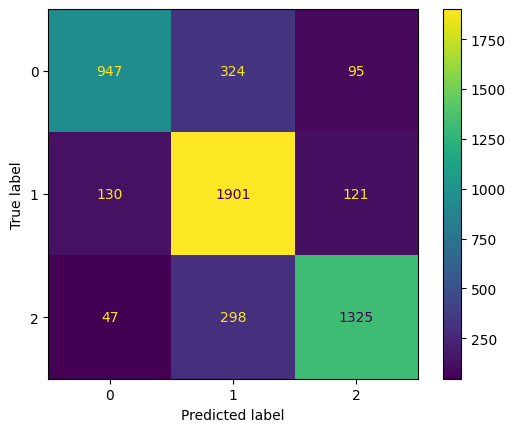

In [ ]:
# Multinomial Naive Bayes
param_grid_nb = {'alpha': [0.8, 0.9, 1.0],  # 0.5, 0.6, 0.7,
                 'fit_prior': [True, False],
                 'force_alpha': [True, False]}

print(name_mnb)
grid(MNB, param_grid_nb, 0)

Logistic Regression (LR)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Grid Search Hyperparameters: {'C': 0.7, 'fit_intercept': True, 'max_iter': 80, 'penalty': 'l2', 'warm_start': True}
Best Grid Search Result on Training Data: 80.30000000000001
Best Model: LogisticRegression(C=0.7, max_iter=80, multi_class='multinomial',
                   solver='newton-cg', warm_start=True)
Average training time for each parameter set: [6.38956761 7.92730999 7.34147515]
Average prediction time for each parameter set: [0.03878498 0.03089023 0.03139005]
Time spent on grid search: 108.80 s
Results obtained on test data.
Accuracy = 81.0%
F1 Score = 80.9%
Classification report:
              precision    recall  f1-score   support

    negative       0.83      0.72      0.77      1366
     neutral       0.77      0.88      0.82      2152
    positive       0.86      0.80      0.83      1670

    accuracy                           0.81      5188
   macro avg       0.82      0.80      0

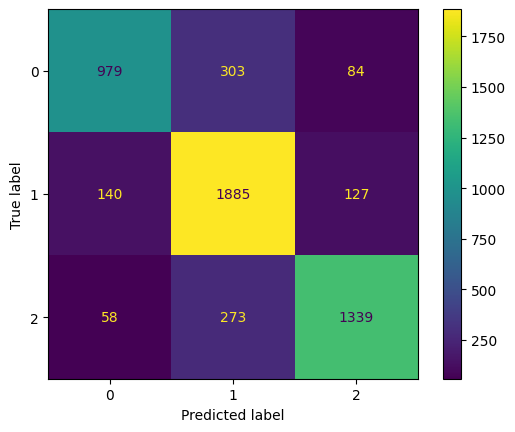

In [ ]:
# Logistic Regression Classifier
param_grid_lr = {'C': [ 0.7,  0.9, 1.0],  # 0.5, 0.6, 0.8,
                 "warm_start": [True],  # , False
                 'fit_intercept': [True],  # , False
                 'max_iter': [80],  # , 100
                 'penalty': ['l2']
                 }
print(name_lr)
grid(LR, param_grid_lr, 1)

Random Forest Classifier (RF)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Grid Search Hyperparameters: {'max_features': 'log2', 'min_samples_split': 9, 'n_estimators': 300}
Best Grid Search Result on Training Data: 80.5
Best Model: RandomForestClassifier(criterion='log_loss', max_features='log2',
                       min_samples_split=9, n_estimators=300)
Average training time for each parameter set: [ 54.42937269 160.45402637  45.4863709  133.81743398  42.23375287
 134.39537106 119.63165293 313.11500721 102.82365732 307.69268279
  99.7939178  278.14339452]
Average prediction time for each parameter set: [1.7319458  4.4096519  1.24949031 3.81341414 1.31527843 3.81100445
 1.0903657  3.17019377 1.01071339 3.00538521 0.99526577 2.68963108]
Time spent on grid search: 9101.54 s
Results obtained on test data.
Accuracy = 81.89999999999999%
F1 Score = 81.69999999999999%
Classification report:
              precision    recall  f1-score   support

    negative       0.85

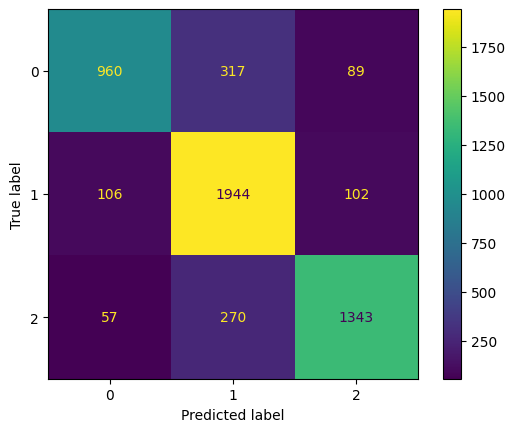

In [ ]:
# Random Forest Model
param_grid_rf = {'max_features': ['log2', 'sqrt'],
                 'n_estimators': [ 100, 300],  # 70, 80,
                 'min_samples_split': [2, 5, 9]  # , 3, 10
                 # 'min_samples_leaf': [1, 2, 3],
                 # 'class_weight': ['balanced_subsample', None, 'balanced']
                 }

print(name_rf)
grid(rf, param_grid_rf, 2)

Voting Classifier (VC)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Grid Search Hyperparameters: {'LR__C': 0.01, 'LR__max_iter': 80, 'MNB__alpha': 1.0, 'MNB__fit_prior': False, 'RF__max_features': 'log2', 'RF__n_estimators': 200}
Best Grid Search Result on Training Data: 81.10000000000001
Best Model: VotingClassifier(estimators=[('MNB', MultinomialNB(fit_prior=False)),
                             ('LR',
                              LogisticRegression(C=0.01, max_iter=80,
                                                 multi_class='multinomial',
                                                 solver='newton-cg')),
                             ('RF',
                              RandomForestClassifier(criterion='log_loss',
                                                     max_features='log2',
                                                     n_estimators=200))],
                 voting='soft')
Average training time for each parameter set: [ 46.22575517 101.

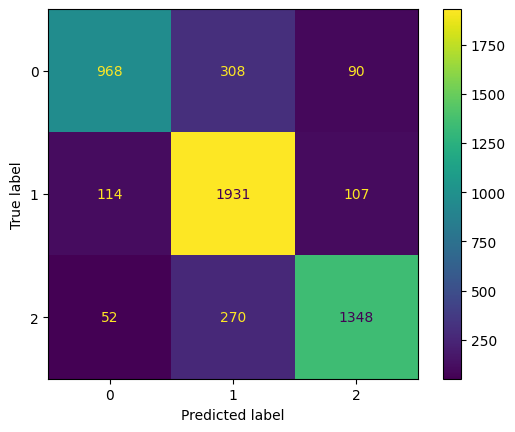

In [ ]:
# Voting Classifier
param_grid_vote = {"MNB__fit_prior": [False],  # , True
                   'MNB__alpha': [0.8, 1.0],  # 0.7,
                   'LR__C': [0.01],  # , 0.1, 0.05
                   'LR__max_iter': [80],  # , 100
                   'RF__max_features': ['log2', 'sqrt'],
                   'RF__n_estimators': [100, 200]
                   }
print(name_vc)
grid(voting, param_grid_vote, 3)

XGBoost Classifier (XGB)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Grid Search Hyperparameters: {'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'max_depth': 5, 'n_estimators': 700, 'subsample': 0.9}
Best Grid Search Result on Training Data: 80.2
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None, num_clas

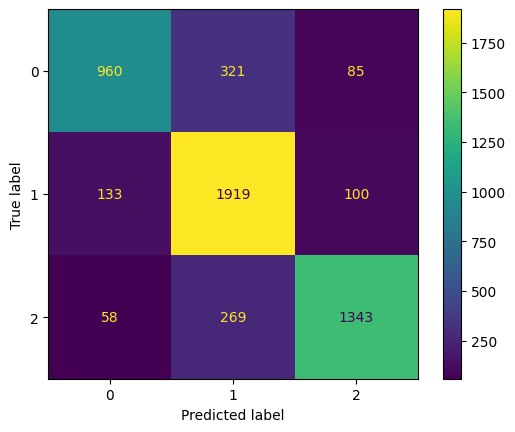

In [ ]:
# XGBClassifier
param_grid_xgb = {"subsample": [0.9],  # , 1.0, 0.7, 0.5
                  #'nthread': [4],
                  'colsample_bytree': [ 0.5],  # [0.75, 1, 0,]
                  # "learning_rate": [0.1, 0.01],
                  'colsample_bylevel': [ 1],  # [0.5, 0,]
                  'colsample_bynode': [0.5, 1, 0],  # []
                  'max_depth': [5, 7],
                  'n_estimators': [500, 700]}


print(name_xgb)
grid(xgb, param_grid_xgb, 4)

Stacking Classifier (SC)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Grid Search Hyperparameters: {'MNB__fit_prior': True, 'MNB__force_alpha': False, 'RF__max_features': 'sqrt', 'RF__n_estimators': 200}
Best Grid Search Result on Training Data: 81.0
Best Model: StackingClassifier(estimators=[('MNB', MultinomialNB(force_alpha=False)),
                               ('RF',
                                RandomForestClassifier(criterion='log_loss',
                                                       n_estimators=200))],
                   final_estimator=LogisticRegression(multi_class='multinomial',
                                                      solver='newton-cg'))
Average training time for each parameter set: [219.86056156 459.40506878 490.54151273 945.54562345]
Average prediction time for each parameter set: [1.2483067  2.67219672 1.16469107 2.00124588]
Time spent on grid search: 10612.20 s
Results obtained on test data.
Accuracy = 81.8%
F1 Score = 81.8%

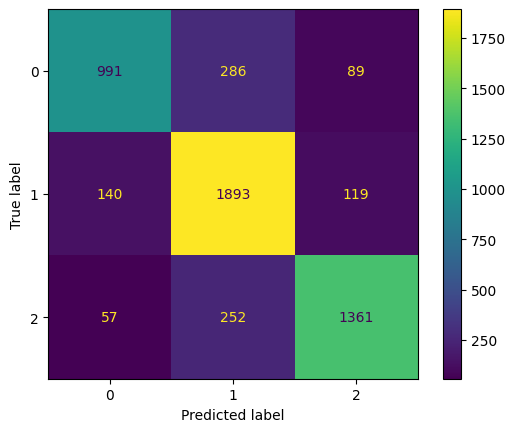

In [ ]:
# Stacking Classifier
param_grid_stack = {"MNB__force_alpha": [False],  # , True
                    "MNB__fit_prior": [True],  # , False
                    'R
                    F__max_features': ['log2', 'sqrt'],
                    # 'MNB__alpha': [0.8, 1.0],
                    # 'RF__min_samples_split': [3, 5],
                    'RF__n_estimators': [100, 200]  # , 70, 300, 500
                    }


print(name_sc)
grid(stacking, param_grid_stack, 5)

In [ ]:
print("Comparison of models after grid search", results_gs)

Comparison of models after grid search                                           Accuracy  Precision  Recall  \
Multinomial Naive Bayes Classifier (MNB)      80.4       81.1    80.4   
Logistic Regression (LR)                      81.0       81.5    81.0   
Random Forest Classifier (RF)                 81.9       82.6    81.9   
Voting Classifier (VC)                        81.9       82.5    81.9   
XGBoost Classifier (XGB)                      81.4       82.0    81.4   
Stacking Classifier (SC)                      81.8       82.2    81.8   

                                          F1-score  
Multinomial Naive Bayes Classifier (MNB)      80.3  
Logistic Regression (LR)                      80.9  
Random Forest Classifier (RF)                 81.7  
Voting Classifier (VC)                        81.8  
XGBoost Classifier (XGB)                      81.3  
Stacking Classifier (SC)                      81.8  
